# **LDA Topic Modelling on Movie Reviews**
Latent Dirichlet Allocation (LDA) is a popular topic modeling technique used to discover abstract topics in a collection of text documents. It assumes that each document is a mixture of topics and that each topic is a mixture of words.

In LDA, the goal is to model a collection of documents (e.g., movie reviews, news articles) by identifying the hidden topics that explain the observed words in the documents. Each document is represented as a distribution over topics, and each topic is represented as a distribution over words.

The core idea of LDA is that documents are mixtures of topics, and topics are mixtures of words. It doesn’t know the topics in advance; instead, it learns them by analyzing word co-occurrences across documents.

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## **1. Install Required Packages**

In [ ]:
!pip install "tweet-preprocessor==0.5.0"
!pip install seaborn
!pip install "networkx==2.6.3"
!pip install "transformers==4.18.0"
!pip install tensorflow
!pip install wordcloud
!pip install protobuf==3.20.3
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('vader_lexicon')
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

## **2. Import Certain Libraries**

In [ ]:
import pandas as pd
import numpy as np
from collections import Counter
import re
import string
import preprocessor as p
import warnings

import nltk
from nltk import word_tokenize, FreqDist, bigrams, trigrams
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns  # Make sure seaborn is imported before using its styles
from wordcloud import WordCloud, STOPWORDS

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report

from tqdm.auto import tqdm
import tensorflow as tf
from tensorflow import keras
from transformers import BertTokenizer
from transformers import TFBertModel
from tensorflow.keras.models import model_from_json

# Apply the style after importing seaborn
plt.style.use('dark_background')

warnings.filterwarnings('ignore')
%matplotlib inline
%config IPCompleter.greedy=True

In [ ]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)

## **3. Load Dataset**

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/BT4222 Project/processed_datasets/movies_and_reviews.csv')
print(df.shape)
df.head()

(798587, 18)


,movie_title,movie_popularity,production_companies,movie_description,movie_cast,movie_duration,movie_genre,movie_director,movie_writer,movie_revenue,movie_year_of_release,reviewer_name,reviewer_rating,review_text,average_cpi,adjustment_factor,adjusted_revenue,revenue_per_minute
0,the birth of a nation (1915),0.00182,['Epoch Film Co.'],"Two families, abolitionist Northerners the Sto...","['Alberta Lee', 'Allan Sears', 'Alma Rubens', ...",194.0,"['Biography', 'Drama', 'History', 'War']","['D.W. Griffith', 'Nate Parker']","['D.W. Griffith', 'Frank E. Woods', 'Nate Park...",15800000.0,1915,Cineanalyst,10.0,"Before ""The Birth of a Nation,"" motion picture...",10.108333,30.970091,4.893274e+08,2.522306e+06
1,the birth of a nation (1915),0.00182,['Epoch Film Co.'],"Two families, abolitionist Northerners the Sto...","['Alberta Lee', 'Allan Sears', 'Alma Rubens', ...",194.0,"['Biography', 'Drama', 'History', 'War']","['D.W. Griffith', 'Nate Parker']","['D.W. Griffith', 'Frank E. Woods', 'Nate Park...",15800000.0,1915,Auburn668,10.0,D.W. Griffith's Civil War shorts were only a p...,10.108333,30.970091,4.893274e+08,2.522306e+06
2,the birth of a nation (1915),0.00182,['Epoch Film Co.'],"Two families, abolitionist Northerners the Sto...","['Alberta Lee', 'Allan Sears', 'Alma Rubens', ...",194.0,"['Biography', 'Drama', 'History', 'War']","['D.W. Griffith', 'Nate Parker']","['D.W. Griffith', 'Frank E. Woods', 'Nate Park...",15800000.0,1915,mozart182,9.0,This is a film which every movie buff really d...,10.108333,30.970091,4.893274e+08,2.522306e+06
3,the birth of a nation (1915),0.00182,['Epoch Film Co.'],"Two families, abolitionist Northerners the Sto...","['Alberta Lee', 'Allan Sears', 'Alma Rubens', ...",194.0,"['Biography', 'Drama', 'History', 'War']","['D.W. Griffith', 'Nate Parker']","['D.W. Griffith', 'Frank E. Woods', 'Nate Park...",15800000.0,1915,smithmjsjsmith,10.0,I can completely understand your frustration w...,10.108333,30.970091,4.893274e+08,2.522306e+06
4,the birth of a nation (1915),0.00182,['Epoch Film Co.'],"Two families, abolitionist Northerners the Sto...","['Alberta Lee', 'Allan Sears', 'Alma Rubens', ...",194.0,"['Biography', 'Drama', 'History', 'War']","['D.W. Griffith', 'Nate Parker']","['D.W. Griffith', 'Frank E. Woods', 'Nate Park...",15800000.0,1915,sharkey197,7.0,As I read these comments on this most controve...,10.108333,30.970091,4.893274e+08,2.522306e+06


### 3.1 Review Exploratory

Minimum review length: 4
Maximum review length: 16540
Mean review length: 1308.92


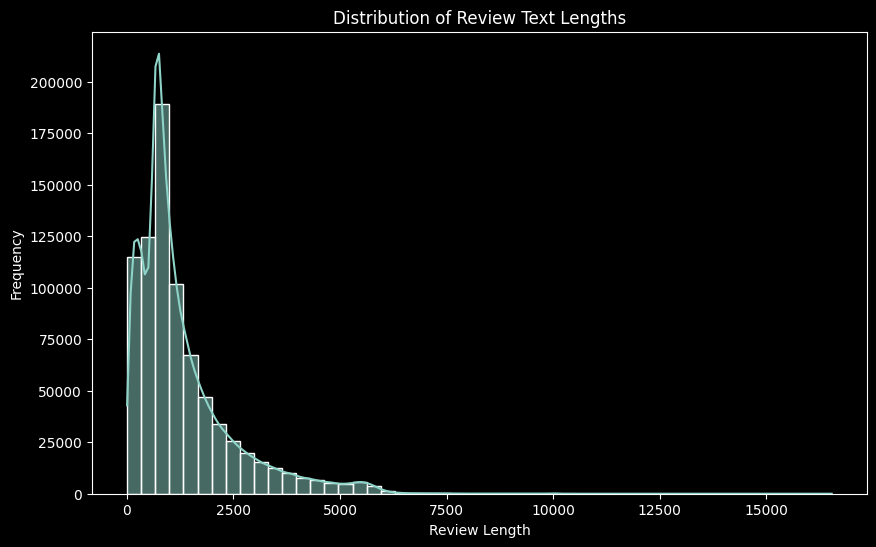

In [ ]:
# Calculate the length of each review
analysis_data = df.copy()
analysis_data['review_length'] = analysis_data['review_text'].apply(len)

# Get the minimum, maximum, and mean of the review lengths
min_length = analysis_data['review_length'].min()
max_length = analysis_data['review_length'].max()
mean_length = analysis_data['review_length'].mean()

print(f"Minimum review length: {min_length}")
print(f"Maximum review length: {max_length}")
print(f"Mean review length: {mean_length:.2f}")

# Plot the histogram of review lengths
plt.figure(figsize=(10,6))
sns.histplot(analysis_data['review_length'], bins=50, kde=True)
plt.title('Distribution of Review Text Lengths')
plt.xlabel('Review Length')
plt.ylabel('Frequency')
plt.show()

**Findings:**
The review length analysis shows that the reviews are quite long, with some going up to 16,540 characters. This large variance in length could be causing challenges in sentiment analysis model, as the longer reviews are likely adding noise or overloading the model, leading to poor performance.

## **4. Feature Engineering**

### 4.1 Sentiment Labelling using Rating

In [ ]:
# Define sentiment based on rating: 1-3 = negative, 4-6 = neutral, 7-10 = positive
def sentiment_label(rating):
    if rating <= 4:
        return "negative"
    elif rating <= 7:
        return "neutral"
    else:
        return "positive"

# Apply function to create sentiment labels
df['sentiment'] = df['reviewer_rating'].apply(sentiment_label)

### 4.2 Keep only necessary columns

In [ ]:
# Assuming your dataset is a pandas DataFrame called df
df = df[['movie_title', 'reviewer_name', 'review_text', 'sentiment']]
df.shape

(798587, 4)

In [ ]:
df.head()

,movie_title,reviewer_name,review_text,sentiment
0,the birth of a nation (1915),Cineanalyst,"Before ""The Birth of a Nation,"" motion picture...",positive
1,the birth of a nation (1915),Auburn668,D.W. Griffith's Civil War shorts were only a p...,positive
2,the birth of a nation (1915),mozart182,This is a film which every movie buff really d...,positive
3,the birth of a nation (1915),smithmjsjsmith,I can completely understand your frustration w...,positive
4,the birth of a nation (1915),sharkey197,As I read these comments on this most controve...,neutral


### 4.3 Textual Preprocessing for Movie Reviews
- Use Stopwords & Lemmatization

In [ ]:
# converting reviews into lower case
def comment_lower(comment):
    return comment.lower()

# removing website links (parts starting with http) from reviews
def remove_links(comment):
    comment = re.sub("https?:\/\/\S+", "", comment)
    return comment

# removing breaks from reviews
def remove_breaks(comment):
    comment = re.sub("<br />", "", comment)
    return comment

# removing numbers
def remove_numbers(comment):
    comment = re.sub(r'\d+', '', str(comment))
    return comment

# removing punctuation from reviews
def remove_punctuation(comment):
    translator = str.maketrans('', '', string.punctuation)
    return comment.translate(translator)

# tokenization of reviews
def tokenize(comment):
    comment = word_tokenize(comment)
    return comment

# removing stopwords from reviews
stop_words = set(stopwords.words('english'))
def remove_stopwords(comment):
    comment = [i for i in comment if not i in stop_words]
    return comment

# lemmatization of reviews
lemmatizer = WordNetLemmatizer()
def lemmatize(comment):
    comment = [lemmatizer.lemmatize(token) for token in comment]
    return comment

def preprocessing(comment):
    comment = comment_lower(comment)
    comment = remove_links(comment)
    comment = remove_breaks(comment)
    comment = remove_numbers(comment)
    comment = remove_punctuation(comment)
    comment = tokenize(comment)
    comment = remove_stopwords(comment)
    comment = lemmatize(comment)
    comment = ' '.join(comment)
    return comment

In [ ]:
import nltk
nltk.download('punkt_tab')

from tqdm import tqdm

clean_reviews = []
for comment in tqdm(df['review_text'], desc="Cleaning reviews", total=len(df)):
    initial_pp_review = p.clean(str(comment))
    preprocessed_review = preprocessing(initial_pp_review)
    clean_reviews.append(preprocessed_review)

df['clean_review'] = clean_reviews
df.head()

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
Cleaning reviews: 100%|██████████| 798587/798587 [20:01<00:00, 664.45it/s] 


,movie_title,reviewer_name,review_text,sentiment,clean_review
0,the birth of a nation (1915),Cineanalyst,"Before ""The Birth of a Nation,"" motion picture...",positive,birth nation motion picture medium potential a...
1,the birth of a nation (1915),Auburn668,D.W. Griffith's Civil War shorts were only a p...,positive,dw griffith civil war short prelude become one...
2,the birth of a nation (1915),mozart182,This is a film which every movie buff really d...,positive,film every movie buff really need see two reas...
3,the birth of a nation (1915),smithmjsjsmith,I can completely understand your frustration w...,positive,completely understand frustration movie secret...
4,the birth of a nation (1915),sharkey197,As I read these comments on this most controve...,neutral,read comment controversial film coming across ...


## **5. Popular Token Identification**

In [ ]:
tokens = []
for comment in df["clean_review"]:
    for token in word_tokenize(comment):
        tokens.append(token)

In [ ]:
print(tokens[:20])

['birth', 'nation', 'motion', 'picture', 'medium', 'potential', 'art', 'movie', 'afore', 'realized', 'promise', 'important', 'film', 'ever', 'made', 'birth', 'art', 'ala', 'also', 'racistbrbrthe']


In [ ]:
FreqDist(tokens).most_common()[:25]

[('movie', 2118074),
 ('film', 1523570),
 ('one', 801059),
 ('like', 664105),
 ('character', 580820),
 ('time', 526247),
 ('good', 516083),
 ('story', 511462),
 ('really', 425443),
 ('see', 423512),
 ('great', 415877),
 ('make', 391934),
 ('scene', 389445),
 ('would', 375207),
 ('get', 363864),
 ('even', 352019),
 ('well', 350725),
 ('much', 348215),
 ('first', 325174),
 ('also', 316304),
 ('best', 306228),
 ('people', 298366),
 ('way', 292842),
 ('dont', 272956),
 ('thing', 272168)]

In [ ]:
fdist = FreqDist(tokens).most_common()[:25]
fdist_dict = dict(fdist)
fdist_dict_sorted = sorted(fdist_dict.items(), key=lambda kv: kv[1], reverse=True)
token, token_counts = list(zip(*fdist_dict_sorted))
token_str = list(map(lambda x: ''.join(x), token))
token_arr = np.array(token_str)
token_counts_arr = np.array(token_counts)

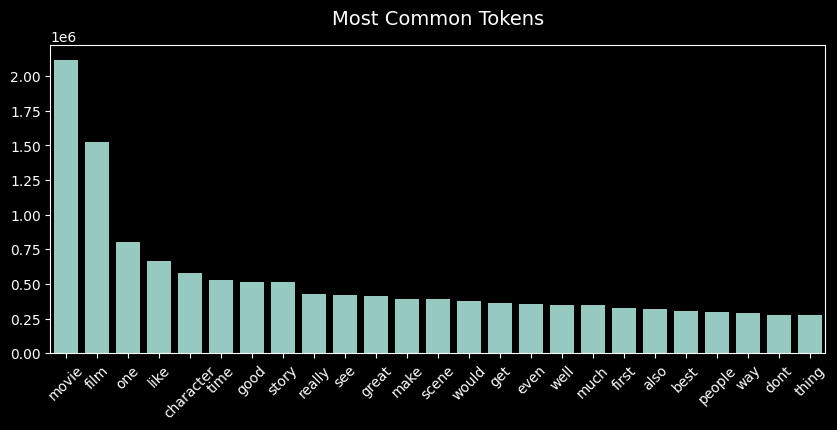

In [ ]:
fig, ax = plt.subplots(figsize=(10, 4))
sns.barplot(x=token_arr, y=token_counts_arr, ax=ax)
for tick in ax.get_xticklabels():
    tick.set_rotation(45)
ax.set_title("Most Common Tokens", fontsize=14, pad=15)
plt.show()

### **5.1. Wordcloud Visualization from Positive reviews**

In [ ]:
Pos_df = df[df['sentiment'] == 'positive']
Pos_df.head()

,movie_title,reviewer_name,review_text,sentiment,clean_review
0,the birth of a nation (1915),Cineanalyst,"Before ""The Birth of a Nation,"" motion picture...",positive,birth nation motion picture medium potential a...
1,the birth of a nation (1915),Auburn668,D.W. Griffith's Civil War shorts were only a p...,positive,dw griffith civil war short prelude become one...
2,the birth of a nation (1915),mozart182,This is a film which every movie buff really d...,positive,film every movie buff really need see two reas...
3,the birth of a nation (1915),smithmjsjsmith,I can completely understand your frustration w...,positive,completely understand frustration movie secret...
7,the birth of a nation (1915),AlsExGal,...yet I still give it an 8/10 for all of the ...,positive,yet still give ground broke brbrwhen released ...


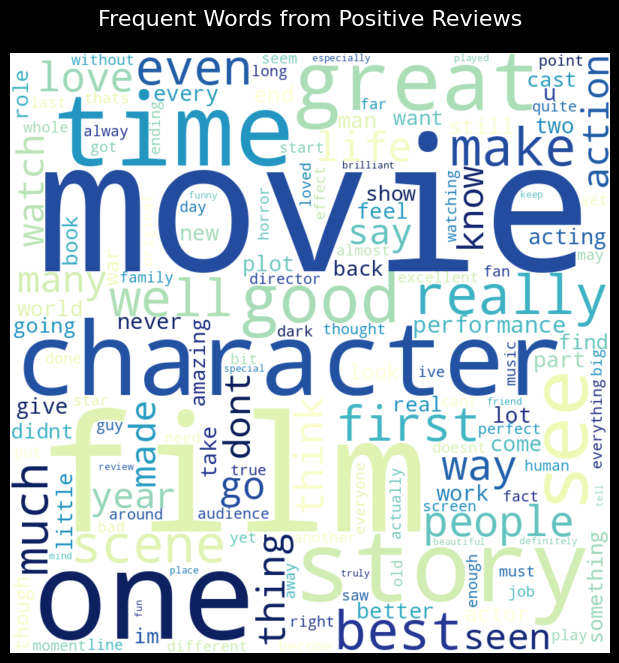

In [ ]:
pos_words = ' '.join(str(review) for review in Pos_df['clean_review'])
wordcloud = WordCloud(width = 800, height = 800,
                      colormap = 'YlGnBu',
                      background_color = 'white',
                      min_font_size = 12,
                      max_words = 150,
                      stopwords = STOPWORDS,
                      collocations = False).generate(pos_words)

plt.figure(figsize = (6, 6), facecolor = None)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad = 0)
plt.title("Frequent Words from Positive Reviews", fontsize=16, pad=20)
plt.show()

### **5.2. Wordcloud Visualization from Negative reviews**

In [ ]:
Neg_df = df[df['sentiment'] == 'negative']
Neg_df.head()

,movie_title,reviewer_name,review_text,sentiment,clean_review
6,the birth of a nation (1915),hughman55,I've read a few of the 10's at this site and a...,negative,ive read site little surprised pas given monum...
9,the birth of a nation (1915),FoxWolf87,A lot of people see this film as an artistic t...,negative,lot people see film artistic triumph fact well...
12,the birth of a nation (1915),soldier9428,"This is one of the longest, most boring, and m...",negative,one longest boring dull movie ever seen everyt...
15,the birth of a nation (1915),nytebyte,This racist film doesn't warrant in-depth crit...,negative,racist film doesnt warrant indepth critique am...
17,the birth of a nation (1915),theseed-1,My opinion of this film is a hateful piece of ...,negative,opinion film hateful piece propaganda ive stud...


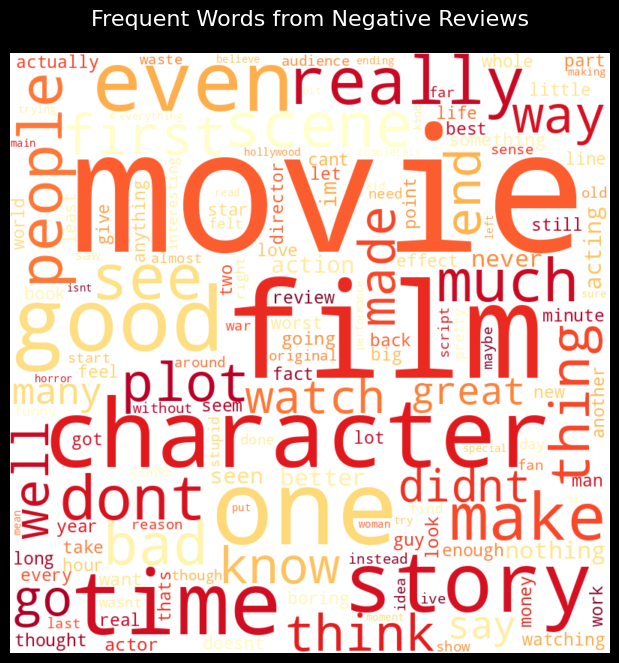

In [ ]:
neg_words = ' '.join(str(review) for review in Neg_df['clean_review'])
wordcloud = WordCloud(width = 800, height = 800,
                      colormap = 'YlOrRd',
                      background_color = 'white',
                      min_font_size = 12,
                      max_words = 150,
                      stopwords = STOPWORDS,
                      collocations = False).generate(neg_words)

plt.figure(figsize = (6, 6), facecolor = None)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad = 0)
plt.title("Frequent Words from Negative Reviews", fontsize=16, pad=20)
plt.show()

## **6. n-gram Analysis**
N-gram analysis is used in natural language processing (NLP) and text analysis to understand and extract patterns of contiguous sequences of n items (such as words or characters) from a given text.

In [ ]:
comment_list = []
for comment in df["clean_review"]:
    tokens = []
    for token in word_tokenize(comment):
        tokens.append(token)
    comment_list.append(tokens)

### **6.1. Bigram Analysis**
A bi-gram is a sequence of two consecutive items (typically words) in a given text.
For example, in the sentence “The movie was fantastic”, the bi-grams are:
(“The”, “movie”)
(“movie”, “was”)
(“was”, “fantastic”)

a. It helps identify which words commonly follow each other, shedding light on word relationships and local context in the text.

b. It is used as features in machine learning models for tasks such as text classification, sentiment analysis, or language modeling. Phrases like “not good” or “very happy” provide more information than single words (unigrams) alone.

c. It helps find collocations, which are pairs of words that occur together more often than would be expected by chance, such as “special effect” or “watch movie”.

In [ ]:
bigrams_list = []
for comment_tokens in comment_list:
    bigrams_list.extend(list(bigrams(comment_tokens)))

In [ ]:
bigrams_freq = Counter(bigrams_list)
bigrams_freq.most_common(25)

[(('special', 'effect'), 56245),
 (('one', 'best'), 55699),
 (('feel', 'like'), 37417),
 (('good', 'movie'), 36603),
 (('see', 'movie'), 36260),
 (('even', 'though'), 34599),
 (('ever', 'seen'), 33990),
 (('main', 'character'), 33355),
 (('dont', 'know'), 32980),
 (('movie', 'like'), 32393),
 (('great', 'movie'), 31896),
 (('movie', 'ever'), 31590),
 (('best', 'movie'), 31298),
 (('comic', 'book'), 30597),
 (('ive', 'seen'), 30514),
 (('first', 'time'), 28632),
 (('star', 'war'), 28515),
 (('watch', 'movie'), 28206),
 (('look', 'like'), 27553),
 (('go', 'see'), 26393),
 (('action', 'scene'), 25588),
 (('movie', 'one'), 24514),
 (('horror', 'movie'), 24260),
 (('action', 'movie'), 23354),
 (('year', 'old'), 23268)]

{'special': array([0.3036819 , 0.84192509]), 'effect': array([0.28340396, 0.84311673]), 'one': array([-0.15308912,  0.05276814]), 'best': array([-0.15932855,  0.07059739]), 'feel': array([-0.10935619,  0.19716725]), 'like': array([-0.1092998 ,  0.15665009]), 'good': array([-0.1454951,  0.1229775]), 'movie': array([-0.13474181,  0.09297382]), 'see': array([-0.0918278,  0.0546466]), 'even': array([ 0.0348716, -1.       ]), 'though': array([ 0.02293709, -0.97937484]), 'ever': array([-0.19137505,  0.12497385]), 'seen': array([-0.23672409,  0.15033193]), 'main': array([-0.16566379, -0.56270836]), 'character': array([-0.18498479, -0.57722877]), 'dont': array([0.22010683, 0.68030065]), 'know': array([0.19574904, 0.68036529]), 'great': array([-0.0957586 ,  0.08787276]), 'comic': array([ 0.66724668, -0.6693366 ]), 'book': array([ 0.69197861, -0.67076858]), 'ive': array([-0.27287315,  0.17016687]), 'first': array([-0.43671502,  0.65381783]), 'time': array([-0.43297442,  0.67892784]), 'star': arr

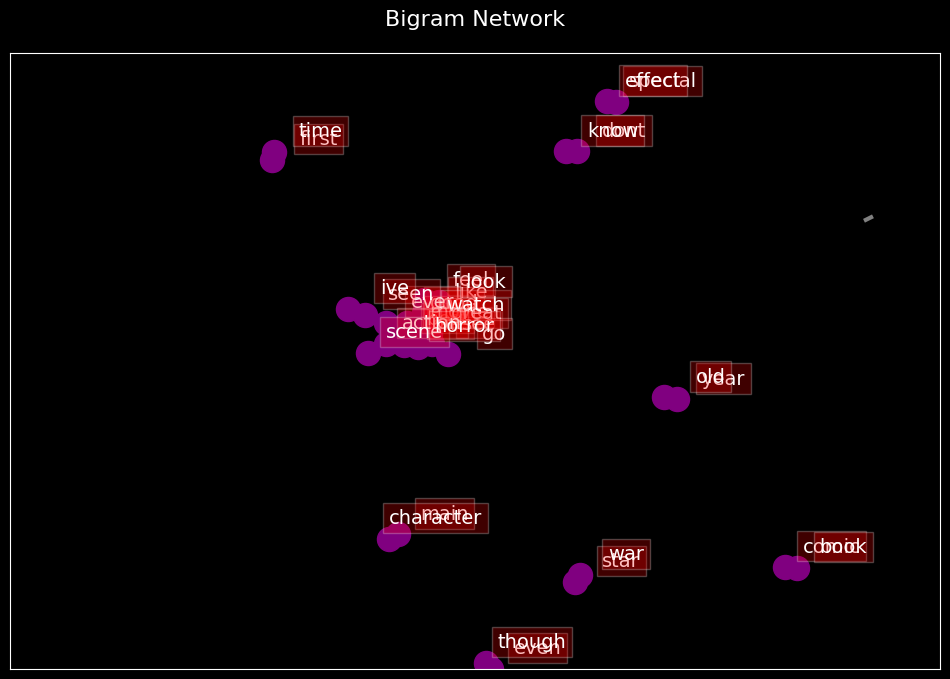

In [ ]:
# Create a graph and add edges with weights based on bigram frequencies
G = nx.Graph()
for b, freq in bigrams_freq.most_common(25):
    G.add_edge(b[0], b[1], weight=freq)

# Plot the graph
plt.figure(figsize=(12, 8))

# Use a different layout algorithm or adjust parameters
pos = nx.spring_layout(G, k=2, iterations=100, seed=42)
# pos = nx.kamada_kawai_layout(G)

# Debug: print node positions
print(pos)

# Draw the graph
nx.draw_networkx(G, pos,
                 font_size=16,
                 width=3,
                 edge_color="grey",
                 node_color="purple",
                 with_labels=False)

# Add offset labels for nodes
for key, value in pos.items():
    x, y = value[0] + 0.1, value[1] + 0.05
    plt.text(x, y, s=key,
             bbox=dict(facecolor="red", alpha=0.25),
             horizontalalignment="center", fontsize=14)

# Add a title and display the plot
plt.title("Bigram Network", fontsize=16, pad=20)
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.show()

### **6.2. Trigram Analysis**

A trigram is a sequence of three consecutive items (typically words) in a given text.
For example, in the sentence “The movie was fantastic and exciting”, the trigrams would be:
(“The”, “movie”, “was”)
(“movie”, “was”, “fantastic”)
(“was”, “fantastic”, “and”)
(“fantastic”, “and”, “exciting”)

a. It captures more context than bigram analysis (which looks at only two consecutive words), allowing it to represent more complex relationships and expressions in the text.

b. They are used in statistical language models to predict the likelihood of a word given the two preceding words, making them more accurate than bigrams for many language generation tasks.

c. By considering sequences of three words, trigram analysis helps better understand phrase structures and patterns that might not be evident with unigrams or bigrams alone.

In [ ]:
trigrams_list = []
for comment_tokens in comment_list:
    trigrams_list.extend(list(trigrams(comment_tokens)))

In [ ]:
trigrams_freq = Counter(trigrams_list)
trigrams_freq.most_common(25)

[(('ive', 'ever', 'seen'), 12983),
 (('one', 'best', 'movie'), 10922),
 (('movie', 'ever', 'made'), 8194),
 (('best', 'movie', 'ever'), 8017),
 (('movie', 'ever', 'seen'), 7671),
 (('one', 'best', 'film'), 7215),
 (('movie', 'ive', 'seen'), 6293),
 (('dont', 'get', 'wrong'), 6138),
 (('saving', 'private', 'ryan'), 6070),
 (('film', 'ever', 'made'), 5876),
 (('samuel', 'l', 'jackson'), 5681),
 (('movie', 'ive', 'ever'), 5643),
 (('comic', 'book', 'movie'), 5579),
 (('go', 'see', 'movie'), 4910),
 (('robert', 'downey', 'jr'), 4422),
 (('based', 'true', 'story'), 4377),
 (('world', 'war', 'ii'), 4009),
 (('film', 'ive', 'seen'), 3782),
 (('robert', 'de', 'niro'), 3674),
 (('batman', 'v', 'superman'), 3490),
 (('best', 'film', 'ever'), 3374),
 (('best', 'movie', 'ive'), 3280),
 (('seen', 'long', 'time'), 3236),
 (('first', 'time', 'saw'), 3235),
 (('film', 'ever', 'seen'), 3210)]

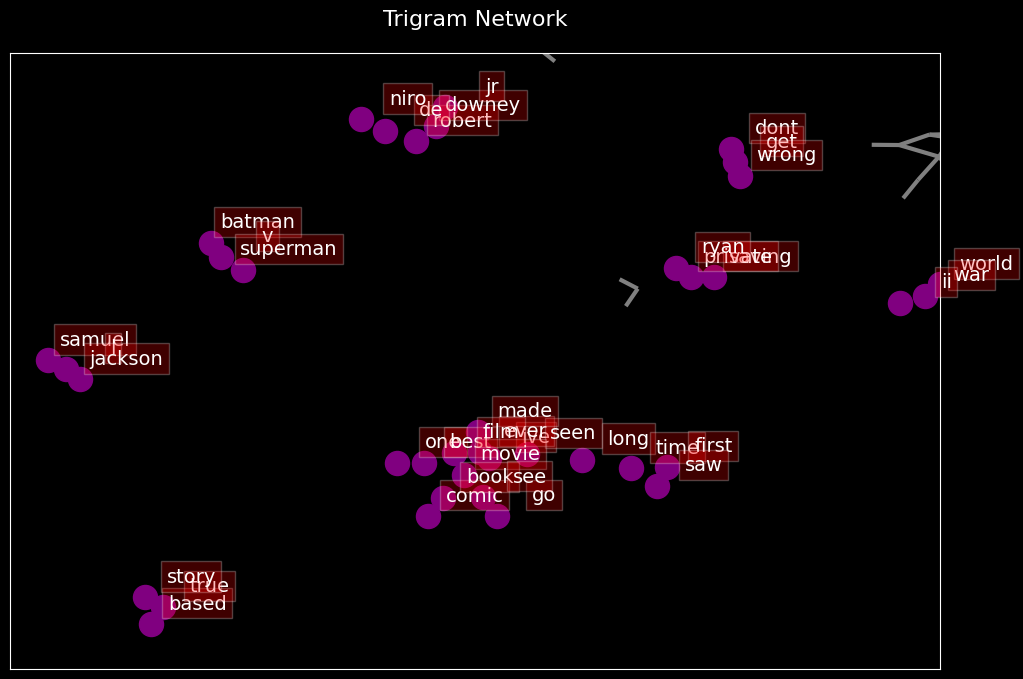

In [ ]:
G = nx.Graph()
for b, freq in trigrams_freq.most_common(25):
    G.add_edge(b[0], b[1], weight=freq)
    G.add_edge(b[1], b[2], weight=freq)

plt.subplots(figsize=(12, 8))
pos = nx.spring_layout(G, k=2)

nx.draw_networkx(G, pos,
                 font_size=16,
                 width=3,
                 edge_color="grey",
                 node_color="purple",
                 with_labels=False)

# create offset labels
for key, value in pos.items():
    x, y = value[0] + 0.1, value[1] + 0.05
    plt.text(x, y, s=key,
             bbox=dict(facecolor="red", alpha=0.25),
             horizontalalignment="center", fontsize=14)

plt.title("Trigram Network", fontsize=16, pad=20)
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.show()

## **7. LDA Topic Modeling**
Latent Dirichlet Allocation (LDA) is a popular statistical model used for topic modeling, which is a technique in natural language processing (NLP) that helps discover the underlying topics in a collection of documents. It is a generative model that models the process of generating a document by first selecting a topic distribution and then generating words from topics.

**Step 1: Initialization**
  - Choose the number of topics k (this is a hyperparameter).
  - Initialize random topic assignments for each word in the corpus.

**Step 2: Iterative Process**
  - LDA uses an iterative algorithm (like Gibbs sampling) to update its topic assignments for words. The key idea is to repeatedly reassign topics to words based on the following:
    - The proportion of words in the document assigned to each topic.
    - The proportion of words assigned to each topic across all documents.

  - At each iteration:
    - For each word in each document:
        - Remove the current topic assignment for that word.
        - Reassign a new topic to that word, based on the current topic-word distribution and the document-topic distribution.

**Step 3: Convergence**
  - The algorithm iterates through the documents multiple times. With each iteration, the topic assignments become more stable, and the algorithm converges to a final set of topic distributions.

### **7.1. Data Preperation**

In [ ]:
comments_for_lda = [" ".join(words) for words in comment_list]
comments_for_lda[:3]

['birth nation motion picture medium potential art movie afore realized promise important film ever made birth art ala also racistbrbrthe film controversy appears left director dw griffith dumbfounded judging griffith response critic description griffith biographer son confederate soldier prepossession antebellum south wasnt still unusual history day including wouldbe u president woodrow wilson supported perverted depiction ku klux klan saving south pillaged carpetbagger scalawag encouraged negro film quote wilson history american people thomas din jr solicited white house screening president said quipped like writing history lightening regret terribly true din racist book trilogy subsequent play griffith inspiration birth nationbrbrin american civil war reconstruction disrupt oncefriendly relation unionist stonemans confederate camerons first part largely free controversy although raciallysegregated imagery underlies nostalgia institution slavery idyllic romanticism melodrama typical 

### **7.2. TF-IDF Vectorization**
TF-IDF (Term Frequency-Inverse Document Frequency) is a statistical measure used to evaluate the importance of a word in a document relative to a collection of documents (corpus). It’s widely used in text processing and Natural Language Processing (NLP) for tasks like text classification, clustering, and topic modeling.

In [ ]:
comments_for_lda = [" ".join(words) for words in comment_list]
tf_vectorizer = CountVectorizer(ngram_range=(1, 2), max_features=5000)
tf = tf_vectorizer.fit_transform(comments_for_lda)
# Use get_feature_names_out() instead of get_feature_names()
tf_feature_names = tf_vectorizer.get_feature_names_out()

### **7.3. Model Training**

1. Assume a fixed number of topics (denoted as K). This is a hyperparameter that must be chosen beforehand.

2. Randomly assign each word in each document to one of the K topics.

3. For each word in the document, LDA computes two things:

    i) The probability of the word being assigned to each topic based on the document’s topic distribution (how likely a document is to contain a particular topic).
    
    ii) The probability of the word belonging to each topic based on the word distribution for each topic (what words are likely to appear in a particular topic).

    These probabilities are updated iteratively to adjust the topic-word and document-topic distributions.

4. After training the LDA model, you get the following outputs:

  i) Topic-Word Distribution:
  - Each topic is represented by a distribution over words. This shows which words are most strongly associated with each topic.

  ii) Document-Topic Distribution:
  - Each document is represented as a distribution over topics. This shows the proportions of topics in each document.
  - For example, a review might be 70% about the "acting" topic and 30% about the "plot" topic.

In [ ]:
from tqdm import tqdm

# Step 2: Set the number of topics and alpha (doc_topic_prior)
num_topics = 10  # Desired number of topics
alpha = 0.1      # Smaller values make topics more distinct; larger values make them more mixed
beta = 0.01      # Controls the distribution of words per topic

# Step 3: Create the LDA model
lda_topic_model = LatentDirichletAllocation(
    n_components=num_topics,
    doc_topic_prior=alpha,
    topic_word_prior=beta,
    max_iter=10,  # Total number of iterations for the progress bar
    random_state=0,
    learning_method='batch',
    verbose=0  # Turn off built-in verbose output
)

# Step 4: Fit the LDA model with a progress bar
with tqdm(total=lda_topic_model.max_iter) as pbar:
    for _ in range(lda_topic_model.max_iter):
        lda_topic_model.partial_fit(tf)  # Train incrementally
        pbar.update(1)

# Step 5: Transform the document-term matrix to get the document-topic distribution
doc_topics = lda_topic_model.transform(tf)

# Extract feature names
tf_feature_names = tf_vectorizer.get_feature_names_out()


100%|██████████| 10/10 [38:09<00:00, 228.99s/it]


In [ ]:
no_top_words = 10
for i, topic in enumerate(lda_topic_model.components_):
    print(i, [tf_feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]])

0 ['performance', 'role', 'actor', 'great', 'cast', 'character', 'well', 'good', 'play', 'also']
1 ['life', 'get', 'one', 'love', 'family', 'go', 'man', 'woman', 'people', 'see']
2 ['marvel', 'character', 'funny', 'original', 'comedy', 'star', 'new', 'song', 'first', 'fun']
3 ['best', 'ever', 'one', 'batman', 'oscar', 'seen', 'one best', 'year', 'superman', 'award']
4 ['movie', 'like', 'dont', 'really', 'good', 'would', 'get', 'didnt', 'much', 'thing']
5 ['movie', 'great', 'good', 'watch', 'story', 'one', 'time', 'see', 'really', 'love']
6 ['film', 'great', 'see', 'time', 'really', 'one', 'story', 'well', 'watch', 'good']
7 ['action', 'horror', 'comic', 'joker', 'dark', 'villain', 'superhero', 'man', 'hero', 'fan']
8 ['war', 'american', 'black', 'battle', 'people', 'soldier', 'world', 'america', 'history', 'movie']
9 ['character', 'film', 'story', 'one', 'scene', 'make', 'time', 'even', 'much', 'plot']


Coherence score measures how semantically similar the words within each topic are to each other.

In the context of movie, a high coherence score indicates that our topics are more meaningful and interpretable. Our topics are more likely represent genuine themes or aspects of films that viewers care about.

In [ ]:
from gensim.models import CoherenceModel
from gensim.corpora import Dictionary

# Step 1: Prepare the data for gensim
# Convert the tokenized document list into a gensim-friendly format
tokenized_documents = [doc.split() for doc in comments_for_lda]  # Ensure `comments_for_lda` is split into tokens
dictionary = Dictionary(tokenized_documents)

# Use tqdm for corpus creation if it's large
corpus = []
for doc in tqdm(tokenized_documents, desc="Creating Corpus"):
    corpus.append(dictionary.doc2bow(doc))

# Step 2: Map the LDA model's topics from sklearn to gensim format
topics = []
for topic_idx, topic in enumerate(lda_topic_model.components_):
    topic_terms = [(tf_feature_names[i], topic[i]) for i in topic.argsort()[-10:][::-1]]
    topics.append([term for term, _ in topic_terms])

# Step 3: Create a CoherenceModel instance with a progress bar
print("Calculating Coherence Score...")
with tqdm(total=1, desc="Coherence Calculation") as pbar:
    coherence_model = CoherenceModel(
        topics=topics,
        texts=tokenized_documents,
        dictionary=dictionary,
        coherence='c_v'
    )
    pbar.update(1)

# Step 4: Get the coherence score
coherence_score = coherence_model.get_coherence()
print(f"Coherence Score: {coherence_score}")


Creating Corpus: 100%|██████████| 798587/798587 [01:12<00:00, 11061.75it/s]


Calculating Coherence Score...


Coherence Calculation: 100%|██████████| 1/1 [00:00<00:00,  2.46it/s]


Coherence Score: 0.43224621248667316


### **7.4 Hyperparameter Tuning**

#### **7.4.1 Tune 1**
- Increase number of topics to 20
- Reduce alpha to 0.001

In [88]:
# Step 2: Set the number of topics and alpha (doc_topic_prior)
num_topics = 20  # Desired number of topics
alpha = 0.001      # Smaller values make topics more distinct; larger values make them more mixed
beta = 0.01      # Controls the distribution of words per topic

# Step 3: Create the LDA model
lda_topic_model_2 = LatentDirichletAllocation(
    n_components=num_topics,
    doc_topic_prior=alpha,
    topic_word_prior=beta,
    max_iter=10,  # Total number of iterations for the progress bar
    random_state=0,
    learning_method='batch',
    verbose=0  # Turn off built-in verbose output
)

# Step 4: Fit the LDA model with a progress bar
with tqdm(total=lda_topic_model_2.max_iter) as pbar:
    for _ in range(lda_topic_model_2.max_iter):
        lda_topic_model_2.partial_fit(tf)  # Train incrementally
        pbar.update(1)

# Step 5: Transform the document-term matrix to get the document-topic distribution
doc_topics_2 = lda_topic_model_2.transform(tf)

# Extract feature names
tf_feature_names_2 = tf_vectorizer.get_feature_names_out()


100%|██████████| 10/10 [47:34<00:00, 285.45s/it]


In [89]:
no_top_words = 10
for i, topic in enumerate(lda_topic_model_2.components_):
    print(i, [tf_feature_names_2[i] for i in topic.argsort()[:-no_top_words - 1:-1]])

0 ['book', 'comic', 'read', 'superman', 'peter', 'novel', 'fan', 'ring', 'read book', 'version']
1 ['movie', 'time', 'see', 'first', 'saw', 'year', 'watched', 'one', 'theater', 'thought']
2 ['song', 'disney', 'music', 'kid', 'animation', 'musical', 'story', 'animated', 'voice', 'child']
3 ['best', 'ever', 'one', 'seen', 'movie', 'ive', 'one best', 'ive seen', 'ever seen', 'movie ever']
4 ['action', 'scene', 'marvel', 'effect', 'movie', 'character', 'special', 'avenger', 'fight', 'special effect']
5 ['good', 'comedy', 'story', 'bad', 'acting', 'pretty', 'best movie', 'best', 'really', 'part']
6 ['visual', 'thriller', 'worth', 'human', 'effect', 'scifi', 'earth', 'graphic', 'creature', 'robot']
7 ['love', 'amazing', 'perfect', 'story', 'see', 'loved', 'comic book', 'havent', 'great', 'beautiful']
8 ['batman', 'joker', 'dark', 'guy', 'superhero', 'hero', 'car', 'bad', 'monster', 'he']
9 ['like', 'would', 'one', 'much', 'get', 'dont', 'even', 'really', 'film', 'thing']
10 ['get', 'go', 'fa

In [ ]:
no_top_words = 10
for topic_idx, topic in enumerate(lda_topic_model_2.components_):
    print(f"Topic {topic_idx}:")
    topic_distribution = topic / topic.sum()  # Normalize to get percentages
    top_words = [(tf_feature_names_2[i], topic_distribution[i]) for i in topic.argsort()[:-no_top_words - 1:-1]]
    for word, proportion in top_words:
        print(f"  {word}: {proportion:.2%}")  # Print as percentages


Topic 0:
  book: 11.58%
  comic: 5.06%
  read: 3.10%
  superman: 2.71%
  peter: 2.43%
  novel: 1.55%
  fan: 1.54%
  ring: 1.49%
  read book: 1.49%
  version: 1.46%
Topic 1:
  movie: 3.51%
  time: 3.36%
  see: 2.72%
  first: 2.14%
  saw: 2.00%
  year: 1.88%
  watched: 1.36%
  one: 1.09%
  theater: 1.08%
  thought: 1.05%
Topic 2:
  song: 3.61%
  disney: 2.72%
  music: 2.63%
  kid: 2.47%
  animation: 2.28%
  musical: 2.08%
  story: 1.94%
  animated: 1.83%
  voice: 1.76%
  child: 1.57%
Topic 3:
  best: 9.39%
  ever: 8.07%
  one: 7.86%
  seen: 7.61%
  movie: 4.94%
  ive: 4.80%
  one best: 3.72%
  ive seen: 2.45%
  ever seen: 2.42%
  movie ever: 2.10%
Topic 4:
  action: 8.31%
  scene: 3.56%
  marvel: 3.48%
  effect: 2.97%
  movie: 2.92%
  character: 2.33%
  special: 2.29%
  avenger: 1.72%
  fight: 1.72%
  special effect: 1.70%
Topic 5:
  good: 16.10%
  comedy: 4.14%
  story: 2.66%
  bad: 2.36%
  acting: 2.33%
  pretty: 2.26%
  best movie: 2.02%
  best: 1.88%
  really: 1.76%
  part: 1.59%
Top

In [ ]:
from gensim.models import CoherenceModel
from gensim.corpora import Dictionary

# Step 2: Map the LDA model's topics from sklearn to gensim format
topics = []
for topic_idx, topic in enumerate(lda_topic_model_2.components_):
    topic_terms = [(tf_feature_names_2[i], topic[i]) for i in topic.argsort()[-10:][::-1]]
    topics.append([term for term, _ in topic_terms])

# Step 3: Create a CoherenceModel instance with a progress bar
print("Calculating Coherence Score...")
with tqdm(total=1, desc="Coherence Calculation") as pbar:
    coherence_model = CoherenceModel(
        topics=topics,
        texts=tokenized_documents,
        dictionary=dictionary,
        coherence='c_v'
    )
    pbar.update(1)

# Step 4: Get the coherence score
coherence_score = coherence_model.get_coherence()
print(f"Coherence Score: {coherence_score}")


Calculating Coherence Score...


Coherence Calculation: 100%|██████████| 1/1 [00:00<00:00, 1201.12it/s]


Coherence Score: 0.459357431917993


#### **7.4.2 Tune 2**
- Reduce alpha to 0.0001

In [75]:
# Step 2: Set the number of topics and alpha (doc_topic_prior)
num_topics = 20  # Desired number of topics
alpha = 0.0001      # Smaller values make topics more distinct; larger values make them more mixed
beta = 0.01      # Controls the distribution of words per topic

# Step 3: Create the LDA model
lda_topic_model_3 = LatentDirichletAllocation(
    n_components=num_topics,
    doc_topic_prior=alpha,
    topic_word_prior=beta,
    max_iter=10,  # Total number of iterations for the progress bar
    random_state=0,
    learning_method='batch',
    verbose=0  # Turn off built-in verbose output
)

# Step 4: Fit the LDA model with a progress bar
with tqdm(total=lda_topic_model_3.max_iter) as pbar:
    for _ in range(lda_topic_model_3.max_iter):
        lda_topic_model_3.partial_fit(tf)  # Train incrementally
        pbar.update(1)

# Step 5: Transform the document-term matrix to get the document-topic distribution
doc_topics_3 = lda_topic_model_3.transform(tf)

# Extract feature names
tf_feature_names_3 = tf_vectorizer.get_feature_names_out()


100%|██████████| 10/10 [45:41<00:00, 274.19s/it]


In [76]:
no_top_words = 10
for i, topic in enumerate(lda_topic_model_3.components_):
    print(i, [tf_feature_names_3[i] for i in topic.argsort()[:-no_top_words - 1:-1]])

0 ['book', 'read', 'monster', 'peter', 'harry', 'novel', 'ring', 'read book', 'version', 'lord']
1 ['time', 'movie', 'see', 'first', 'saw', 'year', 'watched', 'one', 'loved', 'theater']
2 ['song', 'music', 'disney', 'kid', 'animation', 'musical', 'story', 'animated', 'voice', 'child']
3 ['best', 'ever', 'one', 'seen', 'movie', 'ive', 'one best', 'ive seen', 'ever seen', 'movie ever']
4 ['action', 'marvel', 'scene', 'effect', 'movie', 'special', 'fight', 'character', 'avenger', 'special effect']
5 ['good', 'bad', 'story', 'acting', 'pretty', 'best movie', 'guy', 'better', 'best', 'part']
6 ['visual', 'thriller', 'human', 'worth', 'effect', 'scifi', 'graphic', 'earth', 'sound', 'visuals']
7 ['love', 'comic', 'joker', 'comic book', 'perfect', 'havent', 'amazing', 'character', 'villain', 'loved']
8 ['war', 'battle', 'star', 'soldier', 'ryan', 'scott', 'war movie', 'scene', 'saving', 'german']
9 ['like', 'would', 'dont', 'get', 'even', 'much', 'one', 'thing', 'film', 'really']
10 ['get', 'l

In [90]:
no_top_words = 10
for topic_idx, topic in enumerate(lda_topic_model_3.components_):
    print(f"Topic {topic_idx}:")
    topic_distribution = topic / topic.sum()  # Normalize to get percentages
    top_words = [(tf_feature_names_2[i], topic_distribution[i]) for i in topic.argsort()[:-no_top_words - 1:-1]]
    for word, proportion in top_words:
        print(f"  {word}: {proportion:.2%}")  # Print as percentages


Topic 0:
  book: 13.90%
  read: 3.71%
  monster: 3.49%
  peter: 2.86%
  harry: 2.18%
  novel: 1.99%
  ring: 1.79%
  read book: 1.79%
  version: 1.61%
  lord: 1.49%
Topic 1:
  time: 3.19%
  movie: 2.96%
  see: 2.85%
  first: 2.07%
  saw: 1.88%
  year: 1.78%
  watched: 1.25%
  one: 1.14%
  loved: 1.08%
  theater: 1.02%
Topic 2:
  song: 3.53%
  music: 2.71%
  disney: 2.66%
  kid: 2.38%
  animation: 2.23%
  musical: 2.04%
  story: 2.00%
  animated: 1.79%
  voice: 1.68%
  child: 1.49%
Topic 3:
  best: 9.99%
  ever: 8.11%
  one: 8.03%
  seen: 6.89%
  movie: 4.90%
  ive: 4.72%
  one best: 3.98%
  ive seen: 2.46%
  ever seen: 2.43%
  movie ever: 2.11%
Topic 4:
  action: 8.92%
  marvel: 3.71%
  scene: 3.68%
  effect: 3.15%
  movie: 2.73%
  special: 2.32%
  fight: 2.15%
  character: 1.96%
  avenger: 1.83%
  special effect: 1.81%
Topic 5:
  good: 17.68%
  bad: 4.82%
  story: 4.70%
  acting: 3.13%
  pretty: 2.26%
  best movie: 2.08%
  guy: 1.92%
  better: 1.79%
  best: 1.57%
  part: 1.50%
Topic 6:

In [77]:
from gensim.models import CoherenceModel
from gensim.corpora import Dictionary

# Step 2: Map the LDA model's topics from sklearn to gensim format
topics = []
for topic_idx, topic in enumerate(lda_topic_model_3.components_):
    topic_terms = [(tf_feature_names_3[i], topic[i]) for i in topic.argsort()[-10:][::-1]]
    topics.append([term for term, _ in topic_terms])

# Step 3: Create a CoherenceModel instance with a progress bar
print("Calculating Coherence Score...")
with tqdm(total=1, desc="Coherence Calculation") as pbar:
    coherence_model = CoherenceModel(
        topics=topics,
        texts=tokenized_documents,
        dictionary=dictionary,
        coherence='c_v'
    )
    pbar.update(1)

# Step 4: Get the coherence score
coherence_score = coherence_model.get_coherence()
print(f"Coherence Score: {coherence_score}")


Calculating Coherence Score...


Coherence Calculation: 100%|██████████| 1/1 [00:00<00:00, 1483.13it/s]


Coherence Score: 0.47032831541858416


### **7.4. Topic Allocation**


In [80]:
doc_topic_index = [doc_topics_3[i].argmax() for i in range(doc_topics_3.shape[0])]
doc_topic_index[:5]

[15, 12, 12, 18, 12]

In [81]:
df["topic"] = doc_topic_index  # Use the result to add a new column "topic".
df.head()

,movie_title,reviewer_name,review_text,sentiment,clean_review,topic
0,the birth of a nation (1915),Cineanalyst,"Before ""The Birth of a Nation,"" motion picture...",positive,birth nation motion picture medium potential a...,15
1,the birth of a nation (1915),Auburn668,D.W. Griffith's Civil War shorts were only a p...,positive,dw griffith civil war short prelude become one...,12
2,the birth of a nation (1915),mozart182,This is a film which every movie buff really d...,positive,film every movie buff really need see two reas...,12
3,the birth of a nation (1915),smithmjsjsmith,I can completely understand your frustration w...,positive,completely understand frustration movie secret...,18
4,the birth of a nation (1915),sharkey197,As I read these comments on this most controve...,neutral,read comment controversial film coming across ...,12


### **7.5. Visualization of Topic Popularity**

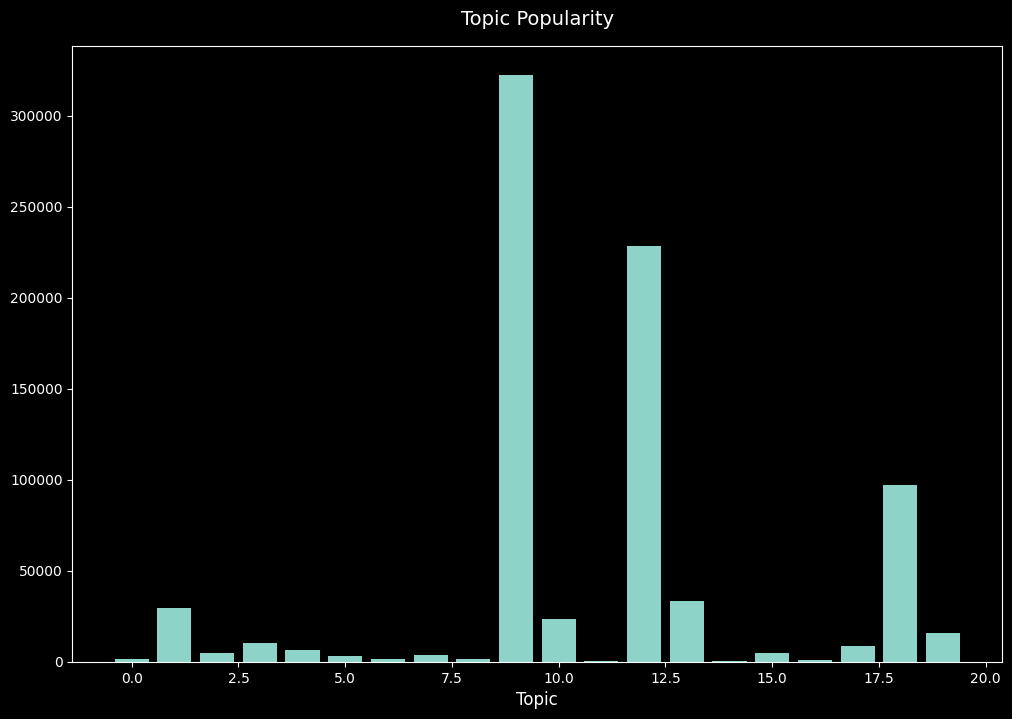

In [82]:
topic_counts = df["topic"].value_counts().sort_index()

plt.figure(figsize=(12, 8))
plt.bar(topic_counts.index, topic_counts)
plt.title("Topic Popularity", fontsize=14, pad=15)
plt.xlabel("Topic", fontsize = 12)
plt.show()

## **8. Recommend Movies Based on LDA Model**


### **8.1. Building Movie Profiles Based on Assigned Topics**
Now that each review is assigned a topic, we build movie profiles by aggregating the topic distribution for all reviews of a given movie.

The purpose of building movie profiles is to create a representation of each movie based on the topics extracted from its reviews.

**Steps:**
- Topic distribution for each movie: For each movie, calculate the distribution of topics based on the reviews for that movie.

- Topic weights: For each review of a movie, the LDA model provides a distribution of topics. By aggregating the topic distributions for all reviews of a particular movie, we can build the overall movie profile.

In [83]:
from tqdm import tqdm
import numpy as np

# Initialize an empty dictionary to store movie profiles
movie_profiles = {}

# Get unique movie titles from the DataFrame
total_movies = len(df['movie_title'].unique())

# Iterate through each movie and aggregate the topic distribution with a progress bar
with tqdm(total=total_movies, desc="Building movie profiles", unit="movie") as pbar:
    for movie_title in df['movie_title'].unique():
        movie_reviews = df[df['movie_title'] == movie_title]

        # Initialize a zero vector for the topic distribution
        movie_topic_distribution = np.zeros(num_topics)

        # Iterate over each review for the current movie
        for review in movie_reviews['review_text']:
            review_vector = tf_vectorizer.transform([review])
            review_topic_dist = lda_topic_model_3.transform(review_vector)

            # Accumulate the topic distribution
            movie_topic_distribution += review_topic_dist.flatten()

        # Normalize the topic distribution by the number of reviews
        if len(movie_reviews) > 0:
            movie_topic_distribution /= len(movie_reviews)

        # Store the movie profile (topic distribution)
        movie_profiles[movie_title] = movie_topic_distribution

        # Update the progress bar
        pbar.update(1)

print("Completed building movie profiles.")


Building movie profiles: 100%|██████████| 2102/2102 [21:42<00:00,  1.61movie/s]

Completed building movie profiles.


### **8.2. Building User Profiles Based on Assigned Topics**
Similarly, we build user profiles by aggregating the topic distributions of the reviews written by each user.

**Steps:**
- Topic distribution for each user: For each user, you can calculate the distribution of topics based on the movies they have reviewed.

- Topic weights: For each review, the topic distribution is obtained. By aggregating the topic distributions for all reviews of a particular user, you can build the user's profile.

In [84]:
from tqdm import tqdm
import numpy as np
from scipy.sparse import vstack

# Initialize an empty dictionary to store user profiles
user_profiles = {}

# Get unique reviewer names from the DataFrame
reviewer_groups = df.groupby('reviewer_name')
total_users = len(reviewer_groups)

# Iterate through each user group and aggregate the topic distribution with a progress bar
with tqdm(total=total_users, desc="Building user profiles", unit="user") as pbar:
    for reviewer_name, user_reviews in reviewer_groups:
        # Transform all reviews in the group at once (vectorized operation)
        review_vectors = tf_vectorizer.transform(user_reviews['review_text'])

        # Get topic distributions for all reviews (batch processing)
        review_topic_dists = lda_topic_model_3.transform(review_vectors)

        # Aggregate the topic distributions (sum and normalize)
        user_topic_distribution = np.sum(review_topic_dists, axis=0)
        if review_topic_dists.shape[0] > 0:
            user_topic_distribution /= review_topic_dists.shape[0]

        # Store the user profile (topic distribution)
        user_profiles[reviewer_name] = user_topic_distribution

        # Update the progress bar
        pbar.update(1)

print("Completed building user profiles.")


Building user profiles: 100%|██████████| 371203/371203 [14:56<00:00, 413.83user/s]

Completed building user profiles.


### **8.3. Using Movie and User Profiles for Recommendations**
Once we obtained both the movie profiles and user profiles, we use cosine similarity to match users with movies they are likely to enjoy based on the topics. The similarity between the user’s topic distribution and the movie’s topic distribution will indicate how well the movie matches the user’s preferences.

Cosine Similarity: Compute the cosine similarity between the user profile and each movie profile to recommend the most relevant movies to the user.

In [85]:
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
import numpy as np

# Create a dictionary mapping each user to the set of movies they have watched
watched_movies_dict = df.groupby('reviewer_name')['movie_title'].apply(set).to_dict()

def recommend_movies(user_profiles, movie_profiles, user_name, top_n=5):
    # Get the user's profile (topic distribution)
    user_profile = user_profiles.get(user_name)

    if user_profile is None:
        print(f"No profile found for user: {user_name}")
        return []

    # Get the movies the user has already watched
    watched_movies = watched_movies_dict.get(user_name, set())

    # Print the watched movies in a single line
    if watched_movies:
        print(f"Movies watched by {user_name}: {', '.join(watched_movies)}\n")
    else:
        print(f"{user_name} has not watched any movies yet.\n")

    # Initialize a dictionary to store similarities
    similarities = {}

    # Calculate the cosine similarity between the user's profile and each movie profile with a progress bar
    with tqdm(total=len(movie_profiles), desc="Calculating similarities", unit="movie") as pbar:
        for movie_title, movie_profile in movie_profiles.items():
            if movie_title in watched_movies:
                pbar.update(1)
                continue  # Skip movies the user has already watched

            # Compute the cosine similarity
            similarity = cosine_similarity([user_profile], [movie_profile])[0][0]
            similarities[movie_title] = similarity
            pbar.update(1)

    # Sort movies by similarity in descending order
    sorted_movies = sorted(similarities.items(), key=lambda x: x[1], reverse=True)

    # Get the top N recommended movies and their similarity scores
    top_recommendations = sorted_movies[:top_n]

    # Print the similarity scores along with the recommended movies
    print("Movie Recommendations based on Similarity Scores (excluding watched movies):")
    for movie_title, similarity_score in top_recommendations:
        print(f"Movie: {movie_title}, Similarity: {similarity_score:.4f}")

    # Return the top N recommended movies
    return [movie_title for movie_title, _ in top_recommendations]


In [86]:
# Example: Recommend top 5 movies for a user
recommended_movies = recommend_movies(user_profiles, movie_profiles, 'Auburn668', top_n=5)
print("\nRecommended Movies:", recommended_movies)

Movies watched by Auburn668: the birth of a nation (1915)



Calculating similarities: 100%|██████████| 2102/2102 [00:00<00:00, 2202.25movie/s]

Movie Recommendations based on Similarity Scores (excluding watched movies):
Movie: bloody sunday (2002), Similarity: 0.9837
Movie: the wind that shakes the barley (2006), Similarity: 0.9811
Movie: detroit (2017), Similarity: 0.9713
Movie: jfk (1991), Similarity: 0.9705
Movie: good night, and good luck. (2005), Similarity: 0.9681

Recommended Movies: ['bloody sunday (2002)', 'the wind that shakes the barley (2006)', 'detroit (2017)', 'jfk (1991)', 'good night, and good luck. (2005)']
